## References

 A. Saxena, K. Goebel, D. Simon, and N. Eklund, “Damage Propagation Modeling 
 for Aircraft Engine Run-to-Failure Simulation”, in the Proceedings of the Ist 
 International Conference on Prognostics and Health Management (PHM08), 
 Denver CO, Oct 2008.


## Introduction

The data used in this project are simulated running data of different 
aircraft's engines, provided by NASA.All engines are of the same type, but 
each engine starts in a different state and has been under different usage 
circumstances.

## Prediction Goal

The main goal of this project is to build a model capable of forecasting the
 Remaining Useful Life(RUL) of an engine (the total amount of engine 
 cycles the are left before failure) .
 
## Data description

We were given 4 training datasets, 4 testing datasets as well as 4 vector 
files which contain the real RUL values (and will be used for model 
evaluation).

Every training dataset contains observations of data of 100 aircraft 
engines,until the cycle before ech engine's failure.

There are 3 given operational settings related to the studied engines which 
can change the performance of each machine.

A total of 58 sensors were used to evaluate the state of the concerned 
engines ,though only 21 sensor results were presented in the datasets.

**In the training datasets, the true RUL is not initially included. 
Although, it can be calculated from the existing data **

For the training and test datasets, the given columns are:

1. engine id
2. time in cycles
3. first operational setting 
4. second operational setting
5. third operational setting 

The 21 sensors measurements:

| Label| Symbol    | Description                    | Unit   |
|------|-----------|------------------------------- |--------|
| sen1 | T2        | Total temperature at fan inlet | °R     |
| sen2 | T24       | Total temperature at LPC outlet| °R     |
| sen3 | T30       | Total temperature at HPC outlet| °R     |
| sen4 | T50       | Total temperature at LPT outlet| °R     |
| sen5 | P2        | Pressure at fan inlet          | psia   |
| sen6 | P15       | Total pressure in bypass-duct  | psia   |
| sen7 | P30       | Total pressure at HPC outlet   | psia   |
| sen8 | Nf        | Physical fan speed             | rpm    |
| sen9 | Nc        | Physical core speed            | rpm    |
| sen10| epr       | Engine pressure ratio (P50/P2) |        |
| sen11| Ps30      | Static pressure at HPC outlet  | psia   |
| sen12| phi       | Ratio of fuel flow to Ps30     | pps/psi|	
| sen13| NRf	   | Corrected fan speed            | rpm    |
| sen14| NRc	   | Corrected core speed 	        | rpm    |
| sen15| BPR	   | Bypass Ratio                   |        |
| sen16| farB	   | Burner fuel-air ratio          |        |	
| sen17| htBleed   | Bleed Enthalpy                 |        |	
| sen18| Nf_dmd    | Demanded fan speed	            | rpm    |
| sen19| PCNfR_dmd | Demanded corrected fan speed	| rpm    |
| sen20| W31       | HPT coolant bleed              | lbm/s  |
| sen21| W32	   | LPT coolant bleed           	| lbm/s  |


The final training dataset has 18 dependent variables with time-series data 
of 20600 data points for each variable. 
 
## Data Loading and Preprocessing

In this section, we will import both training and testing datasets. Then we 
will clean the data and handle missing values.

(We will use *train_FD001.txt* and *test_FD001.txt*)


In [12]:
# Import libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [13]:
# Load training dataset
df_train = pd.read_csv("train_FD001.txt", sep = " ", header = None)
# Load testing dataset
df_test = pd.read_csv("test_FD001.txt", sep = " ", header = None)
# Load True RUL values
true_RUL = pd.read_csv("RUL_FD001.txt", sep = "\n", header = None)

In [14]:
# Add headers to all datasets
headers = ["id", "cycle", "oper_set_1", "oper_set_2","oper_set_3", "sen1",
           "sen2","sen3", "sen4","sen5", "sen6", "sen7", "sen8","sen9",
           "sen10","sen11","sen12","sen13","sen14","sen15","sen16","sen17",
           "sen18","sen19","sen20","sen21","sen22","sen23"]

df_train.columns = headers
df_test.columns = headers
true_RUL.reset_index(level = 0, inplace = True)
true_RUL.columns = ["id","RUL"]

In [15]:
# drop empty columns

# from the training data 
df_train_pr=df_train.copy()
df_train_pr.drop("sen22",axis = 1, inplace=True)
df_train_pr.drop("sen23",axis = 1, inplace=True)


# from the test data
df_test_pr=df_test.copy()
df_test_pr.drop("sen22",axis = 1, inplace=True)
df_test_pr.drop("sen23",axis = 1, inplace=True)

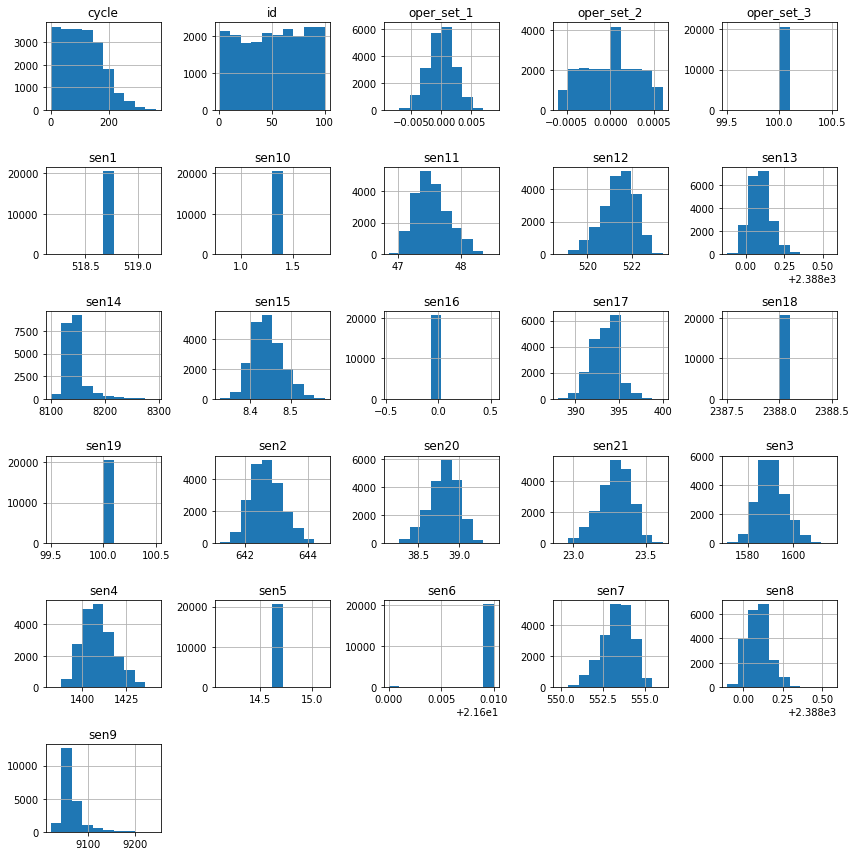

In [16]:
# check for possible independent variables
fig = plt.figure(figsize = (12,12))
ax = fig.gca()
df_train_pr.hist(ax =ax)
plt.tight_layout()
plt.show()

As we can see from the diagrams there are some independent variables (sen1,
sen5, sens6, sen16, sen18, sen19, sen10 and oper_set_3) that don't change 
within  time/cycles .So we drop these variables.

In [17]:
# drop independent variables

#from  training data
df_train_min=df_train_pr.copy()
df_train_min.drop('oper_set_3',axis = 1, inplace=True)
df_train_min.drop("sen1",axis = 1, inplace=True)
df_train_min.drop("sen5",axis = 1, inplace=True)
df_train_min.drop("sen6",axis = 1, inplace=True)
df_train_min.drop("sen10",axis = 1, inplace=True)
df_train_min.drop("sen16",axis = 1, inplace=True)
df_train_min.drop("sen18",axis = 1, inplace=True)
df_train_min.drop("sen19",axis = 1, inplace=True)

#from testing data
df_test_min=df_test_pr.copy()
df_test_min.drop('oper_set_3',axis = 1, inplace=True)
df_test_min.drop("sen1",axis = 1, inplace=True)
df_test_min.drop("sen5",axis = 1, inplace=True)
df_test_min.drop("sen6",axis = 1, inplace=True)
df_test_min.drop("sen10",axis = 1, inplace=True)
df_test_min.drop("sen16",axis = 1, inplace=True)
df_test_min.drop("sen18",axis = 1, inplace=True)
df_test_min.drop("sen19",axis = 1, inplace=True)


Now we have to add target variable, which is RUL column. 

For each engine, we will calculate the maximum cycle reached. Then for each 
row, we will subtract the current cycle number from that max.

In [18]:
# for training set

# hold the last running cycle for each engine
df_max = pd.DataFrame(df_train_min.groupby('id')['cycle'].max())
df_max.reset_index(level = 0, inplace = True)
df_max.columns = ['id', 'last_cycle']

# add RUL as a new column to the training set
df_train_min = pd.merge(df_train_min, df_max, on = 'id')
df_train_min['RUL'] = df_train_min['last_cycle'] - df_train_min['cycle']
# df_train_min.drop(['last_cycle'], axis = 1, inplace = True)


## Data Standardization


In [19]:
features = ["oper_set_1","oper_set_2","sen2","sen3","sen4","sen7","sen8", 
            "sen9","sen11","sen12","sen13","sen14","sen15","sen17","sen20", 
            "sen21"]

x_train_pr = df_train_min.loc[:, features].values
sc = preprocessing.StandardScaler().fit(x_train_pr)
x_train_pr =sc.transform(x_train_pr)


#adding back the 'unit' ,'cycle' and  'RUL' columns
df_train_std = pd.DataFrame(x_train_pr)
df_train_std.columns = features
df_train_std.insert (0, 'id', df_train_min["id"])
df_train_std.insert (1, 'cycle', df_train_min["cycle"])
df_train_std.insert (18, 'RUL', df_train_min['RUL'])

x_test_pr = df_test_min.loc[:, features].values
x_test_pr =sc.transform(x_test_pr)
df_test_std = pd.DataFrame(x_test_pr)
df_test_std.columns = features
df_test_std.insert (0, 'id', df_test["id"])
df_test_std.insert (1, 'cycle', df_test["cycle"])

In [20]:
# Merging the true RUL values with the test dataset
features = ["id","cycle","oper_set_1","oper_set_2","sen2","sen3","sen4",
            "sen7","sen8","sen9","sen11","sen12","sen13","sen14","sen15","sen17","sen20","sen21"]
df_pr = pd.DataFrame(columns=features)
#We select the last entry for each unit in the test set then we append to it its 
# corresponding True RUL value from TrueRUL
a=0
for i in range(0,len(df_test_std)):
    if df_test_std['id'].values[i] != a:
            df_pr=df_pr.append(df_test_std.iloc[i-1])
            a=a+1
df_test_red = df_pr.sort_values('id', axis=0, ascending=True).reset_index(drop=True)
df_test_red=df_test_red[:100]


## Linear Regression with sklearn SGDRegressor

In [21]:
features = ["oper_set_1","oper_set_2","sen2","sen3","sen4","sen7","sen8", 
            "sen9","sen11","sen12","sen13","sen14","sen15","sen17","sen20", 
            "sen21"]

x_train = df_train_std[features]
x_test = df_test_red[features]
y_train = df_train_std[['RUL']]
y_test = true_RUL[['RUL']]

 
 
# run sgd with sklearn
iterations = 1000
reg = linear_model.LinearRegression()
reg.fit(x_train, y_train)

#  variance score: 1 means perfect prediction 
print('Variance score: {}'.format(reg.score(x_test, y_test)))

print("coefficients", reg.coef_)

Variance score: 0.40543440405266107
coefficients [[ 0.11402327  0.44470366 -3.41069656 -2.69418871 -6.89264187  6.11245866
  -0.94298777 -7.71732859 -9.96829353  7.84471231 -0.88230512 -5.21109784
  -4.5031393  -2.86995661  3.59982532  4.44808208]]


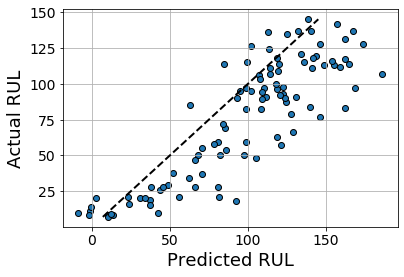

In [22]:
fig, ax = plt.subplots()
ax.scatter(reg.predict(x_test), y_test, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw = 2)
ax.grid()
ax.set_xlabel('Predicted RUL', fontsize = 18)
ax.set_ylabel('Actual RUL', fontsize = 18)
ax.tick_params(axis='both', which='major', labelsize = 14)

plt.show()